# 8. 分析句子结构

前面的章节重点关注词：如何识别它们，分析它们的结构，分配给他们词汇类别，以及获得它们的含义。我们还看到了如何识别词序列或n-grams中的模式。然而，这些方法只触碰到支配句子的复杂约束的表面。我们需要一种方法处理自然语言中显著的歧义。我们还需要能够应对这样一个事实，句子有无限的可能，而我们只能写有限的程序来分析其结构和发现它们的含义。

本章的目的是要回答下列问题：

1. 我们如何使用形式化语法来描述无限的句子集合的结构？
2. 我们如何使用句法树来表示句子结构？
3. 语法分析器如何分析一个句子并自动构建句法树？

一路上，我们将覆盖英语句法的基础，并看到句子含义有系统化的一面，只要我们确定了句子结构，将更容易捕捉。

<a href="#1-一些语法困境">1 一些语法困境</a> 

<a href="#3">3.3  句法结构中的递归</a> 

<a href="#4">4.2 移进-归约分析</a> 

<a href="#5-依存关系和依存文法">5 依存关系和依存文法</a> 

<a href="#6-语法开发">6 语法开发</a> 

<a href="#7-小结">7 小结</a> 

<a href="#8-深入阅读">8 深入阅读</a> 

<a href="#9-练习">9 练习</a> 

## 1 一些语法困境

## 1.1 语言数据和无限可能性

前面的章节中已经为你讲述了如何处理和分析的文本语料库，我们一直强调处理大量的每天都在增加的电子语言数据是NLP的挑战。让我们更加细致的思考这些数据，做一个思想上的实验，我们有一个巨大的语料库，包括在过去50年中英文表达或写成的一切。我们称这个语料库为“现代英语”合理吗？有许多为什么我们的回答可能是否定的的原因。回想一下，在[3](https://usyiyi.github.io/nlp-py-2e-zh/3.html#chap-words)中，我们让你搜索网络查找the of模式的实例。虽然很容易在网上找到包含这个词序列的例子，例如New man at the of IMG （见`http://www.telegraph.co.uk/sport/2387900/New-man-at-the-of-IMG.html`），说英语的人会说大多数这样的例子是错误的，因此它们根本不是英语。

因此，我们可以说，“现代英语”并不等同于我们想象中的语料库中的非常大的词序列的集合。说英语的人可以判断这些序列，并将拒绝其中一些不合语法的。

同样，组成一个新的句子，并让说话者认为它是非常好的英语是很容易的。例如，句子有一个有趣的属性，它们可以嵌入更大的句子中。考虑下面的句子：

In [1]:
import nltk

In [12]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")

这个文法允许以两种方式分析句子，取决于介词短语in my pajamas是描述大象还是枪击事件。

In [3]:
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
for tree in parser.parse(sent):
    print(tree)

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


程序产生两个括号括起的结构，我们可以用树来表示它们，如[(3b)](https://usyiyi.github.io/nlp-py-2e-zh/8.html#ex-elephant)所示：

In [29]:
grammar1 = nltk.CFG.fromstring("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)

在[3.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-cfg1)中的语法包含涉及各种句法类型的产生式，如在[3.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#tab-syncat)中所列出的。

表 3.1：

句法类型

In [31]:
grammar1 = nltk.data.load('mygrammar.cfg')
# 要执行上一行代码，请到仓库下载 mygrammar.cfg 文件放到当前目录
# 或者注释掉上一行代码直接使用上一个代码块的 grammar1
sent = "Mary saw Bob".split()
rd_parser = nltk.RecursiveDescentParser(grammar1)
for tree in rd_parser.parse(sent):
     print(tree)

(S (NP Mary) (VP (V saw) (NP Bob)))


确保你的文件名后缀为`.cfg`，并且字符串`'file:mygrammar.cfg'`中间没有空格符。如果命令`print(tree)`没有产生任何输出，这可能是因为你的句子`sent`并不符合你的语法。在这种情况下，可以将分析器的跟踪设置打开：`rd_parser = nltk.RecursiveDescentParser(grammar1, trace=2)`。你还可以查看当前使用的语法中的产生式，使用命令`for p in grammar1.productions(): print(p)`。

当你编写CFG在NLTK中分析时，你不能将语法类型与词汇项目一起写在同一个产生式的右侧。因此，产生式`PP -> 'of' NP`是不允许的。另外，你不得在产生式右侧仿制多个词的词汇项。因此，不能写成`NP -> 'New York'`，而要写成类似`NP -> 'New_York'`这样的。

<a id="3"></a>

## 3.3 句法结构中的递归

一个语法被认为是递归的，如果语法类型出现在产生式左侧也出现在右侧，如[3.3](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-cfg2)所示。产生式`Nom -> Adj Nom`（其中`Nom`是名词性的类别）包含`Nom`类型的直接递归，而`S`上的间接递归来自于两个产生式的组合`S -> NP VP`和`VP -> V S`。

In [5]:
grammar2 = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> Det Nom | PropN
  Nom -> Adj Nom | N
  VP -> V Adj | V NP | V S | V NP PP
  PP -> P NP
  PropN -> 'Buster' | 'Chatterer' | 'Joe'
  Det -> 'the' | 'a'
  N -> 'bear' | 'squirrel' | 'tree' | 'fish' | 'log'
  Adj  -> 'angry' | 'frightened' |  'little' | 'tall'
  V ->  'chased'  | 'saw' | 'said' | 'thought' | 'was' | 'put'
  P -> 'on'
  """)

要看递归如何从这个语法产生，思考下面的树。[(10a)](https://usyiyi.github.io/nlp-py-2e-zh/8.html#ex-recnominals)包括嵌套的名词短语，而[(10b)](https://usyiyi.github.io/nlp-py-2e-zh/8.html#ex-recsentences)包含嵌套的句子。

In [13]:
rd_parser = nltk.RecursiveDescentParser(grammar1)
sent = 'Mary saw a dog'.split()
for tree in rd_parser.parse(sent):
    print(tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


注意

`RecursiveDescentParser()`接受一个可选的参数`trace`。如果`trace`大于零，则分析器将报告它解析一个文本的步骤。

递归下降分析有三个主要的缺点。首先，左递归产生式，如`NP -> NP PP`会进入死循环。第二，分析器浪费了很多时间处理不符合输入句子的词和结构。第三，回溯过程中可能会丢弃分析过的成分，它们将需要在之后再次重建。例如，从`VP -> V NP`上回溯将放弃为`NP`创建的子树。如果分析器之后处理`VP -> V NP PP`，那么`NP`子树必须重新创建。

递归下降分析是一种自上而下分析。自上而下分析器在检查输入之前先使用文法*预测*输入将是什么！然而，由于输入对分析器一直是可用的，从一开始就考虑输入的句子会是更明智的做法。这种方法被称为自下而上分析，在下一节中我们将看到一个例子。

<a id="4"></a>

## 4.2 移进-归约分析

一种简单的自下而上分析器是移进-归约分析器。与所有自下而上的分析器一样，移进-归约分析器尝试找到对应文法生产式*右侧*的词和短语的序列，用左侧的替换它们，直到整个句子归约为一个`S`。

移位-规约分析器反复将下一个输入词推到堆栈（[4.1](https://usyiyi.github.io/nlp-py-2e-zh/4.html#sec-back-to-the-basics)）；这是移位操作。如果堆栈上的前*n*项，匹配一些产生式的右侧的*n*个项目，那么就把它们弹出栈，并把产生式左边的项目压入栈。这种替换前*n*项为一项的操作就是规约操作。此操作只适用于堆栈的顶部；规约栈中的项目必须在后面的项目被压入栈之前做。当所有的输入都使用过，堆栈中只剩余一个项目，也就是一颗分析树作为它的根的`S`节点时，分析器完成。移位-规约分析器通过上述过程建立一颗分析树。每次弹出堆栈*n*个项目，它就将它们组合成部分的分析树，然后将这压回推栈。我们可以使用图形化示范`nltk.app.srparser()`看到移位-规约分析算法步骤。执行此分析器的六个阶段，如[4.2](https://usyiyi.github.io/nlp-py-2e-zh/8.html#fig-srparser1-6)所示。

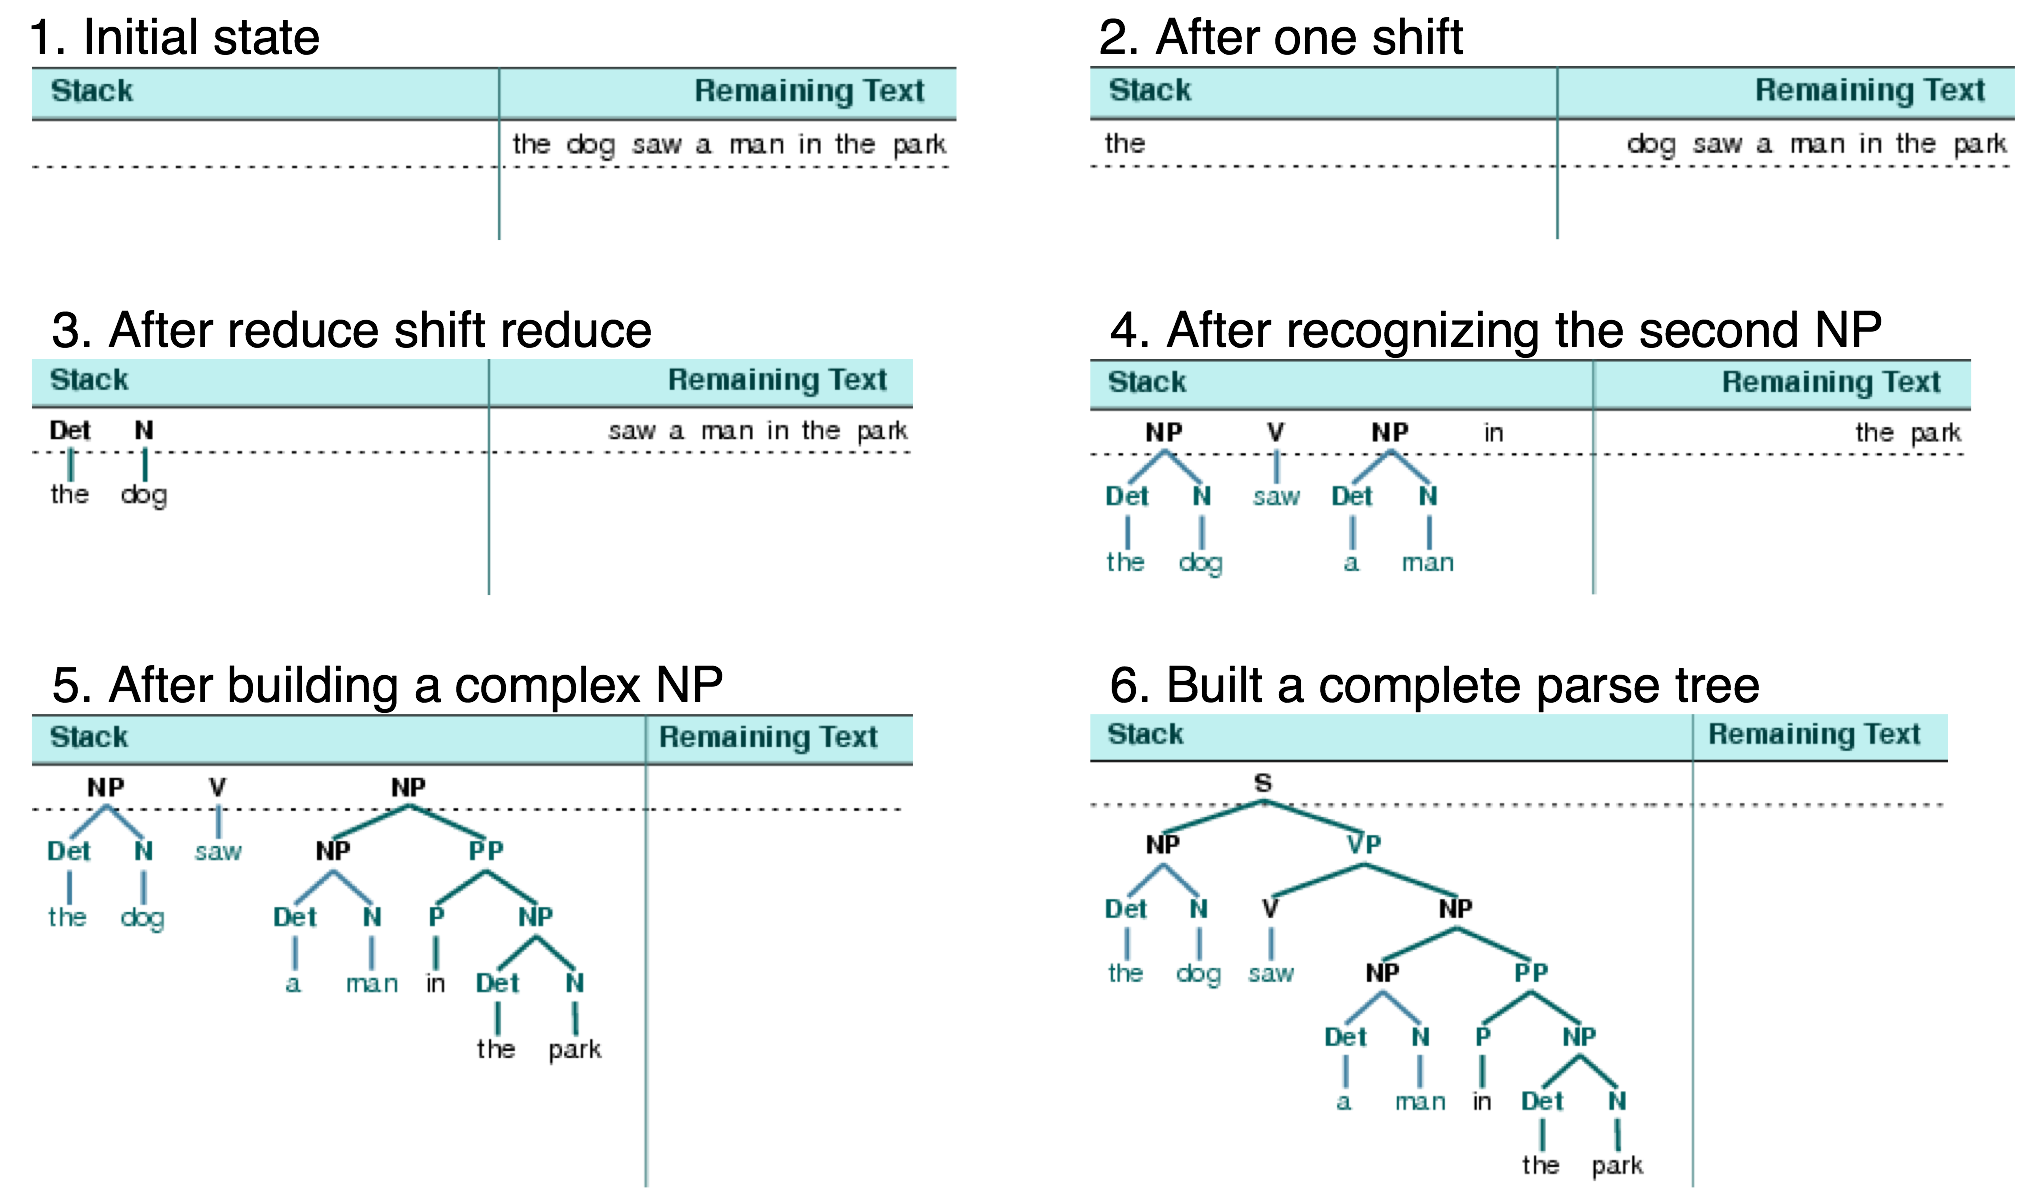

图 4.2：移进-归约分析器的六个阶段：分析器一开始把输入的第一个词转移到堆栈；一旦堆栈顶端的项目与一个文法产生式的右侧匹配，就可以将它们用那个产生式的左侧替换；当所有输入都被使用过且堆栈中只有剩余一个项目`S`时，分析成功。

NLTK中提供`ShiftReduceParser()`，移进-归约分析器的一个简单的实现。这个分析器不执行任何回溯，所以它不能保证一定能找到一个文本的解析，即使确实存在一个这样的解析。此外，它最多只会找到一个解析，即使有多个解析存在。我们可以提供一个可选的`trace`参数，控制分析器报告它分析一个文本的步骤的繁琐程度。

In [7]:
sr_parser = nltk.ShiftReduceParser(grammar1)
sent = 'Mary saw a dog'.split()
for tree in sr_parser.parse(sent):
    print(tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


注意

**轮到你来：** 以跟踪模式运行上述分析器，看看序列的移进和规约操作，使用`sr_parse = nltk.ShiftReduceParser(grammar1, trace=2)`。

移进-规约分析器可能会到达一个死胡同，而不能找到任何解析，即使输入的句子是符合语法的。这种情况发生时，没有剩余的输入，而堆栈包含不能被规约到一个`S`的项目。问题出现的原因是较早前做出的选择不能被分析器撤销（虽然图形演示中用户可以撤消它们的选择）。分析器可以做两种选择：（a）当有多种规约可能时选择哪个规约（b）当移进和规约都可以时选择哪个动作。

移进-规约分析器可以改进执行策略来解决这些冲突。例如，它可以通过只有在不能规约时才移进，解决移进-规约冲突；它可以通过优先执行规约操作，解决规约-规约冲突；它可以从堆栈移除更多的项目。（一个通用的移进-规约分析器，是一个“超前LR 分析器”，普遍使用在编程语言编译器中。）

移进-规约分析器相比递归下降分析器的好处是，它们只建立与输入中的词对应的结构。此外，每个结构它们只建立一次，例如`NP(Det(the), N(man))`只建立和压入栈一次，不管以后`VP -> V NP PP`规约或者`NP -> NP PP`规约会不会用到。

## 4.3 左角落分析器

递归下降分析器的问题之一是当它遇到一个左递归产生式时，会进入无限循环。这是因为它盲目应用文法产生式而不考虑实际输入的句子。左角落分析器是我们已经看到的自下而上与自上而下方法的混合体。

语法`grammar1`允许我们对John saw Mary生成下面的分析：

In [14]:
text = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
groucho_grammar.productions(rhs=text[1])

[V -> 'shot']

对于我们的WFST，我们用Python中的列表的咧表创建一个(n-1) × (n-1)的矩阵，在[4.4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-wfst)中的函数`init_wfst()`中用每个标识符的词汇类型初始化它。我们还定义一个实用的函数`display()`来为我们精美的输出WFST。正如预期的那样，`V`在(1, 2)单元中。

In [15]:
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    wfst = [[None for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        wfst[i][i+1] = productions[0].lhs()
    return wfst

def complete_wfst(wfst, tokens, grammar, trace=False):
    index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                if nt1 and nt2 and (nt1,nt2) in index:
                    wfst[start][end] = index[(nt1,nt2)]
                    if trace:
                        print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                        (start, nt1, mid, nt2, end, start, index[(nt1,nt2)], end))
    return wfst

def display(wfst, tokens):
    print('\nWFST ' + ' '.join(("%-4d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-4s" % (wfst[i][j] or '.'), end=" ")
        print()
tokens = "I shot an elephant in my pajamas".split()
wfst0 = init_wfst(tokens, groucho_grammar)
display(wfst0, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    .    .    .    .    
1    .    V    .    .    .    .    .    
2    .    .    Det  .    .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    .    
5    .    .    .    .    .    Det  .    
6    .    .    .    .    .    .    N    


回到我们的表格表示，假设对于词an我们有`Det`在(2, 3)单元，对以词elephant有`N`在(3, 4)单元，对于an elephant我们应该在(2, 4)放入什么？我们需要找到一个形如*A* → `Det N`的产生式。查询了文法，我们知道我们可以输入(0, 2)单元的`NP`。

更一般的，我们可以在(i, j)输入*A*，如果有一个产生式*A* → *B* *C*，并且我们在(i, k)中找到非终结符*B*，在(k, j)中找到非终结符*C*。[4.4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-wfst)中的程序使用此规则完成WFST。通过调用函数`complete_wfst()`时设置 `trace`为`True`，我们看到了显示WFST正在被创建的跟踪输出：

In [16]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar, trace=True)

[2] Det [3]   N [4] ==> [2]  NP [4]
[5] Det [6]   N [7] ==> [5]  NP [7]
[1]   V [2]  NP [4] ==> [1]  VP [4]
[4]   P [5]  NP [7] ==> [4]  PP [7]
[0]  NP [1]  VP [4] ==> [0]   S [4]
[1]  VP [4]  PP [7] ==> [1]  VP [7]
[0]  NP [1]  VP [7] ==> [0]   S [7]


例如，由于我们在`wfst[2][3]`找到`Det`，在`wfst[3][4]`找到`N`，我们可以添加`NP`到`wfst[2][4]`。

注意

为了帮助我们更简便地通过产生式的右侧检索产生式，我们为语法创建一个索引。这是空间-时间权衡的一个例子：我们对语法做反向查找，每次我们想要通过右侧查找产生式时不必遍历整个产生式列表。

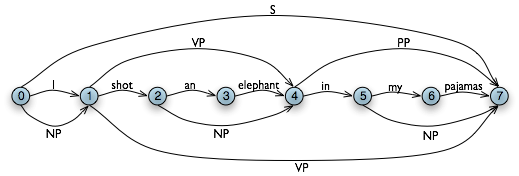

图 4.5：图数据结构：图中额外的边表示非终结符。

我们得出结论，只要我们已经在(0, 7)单元构建了一个`S`节点，表明我们已经找到了一个涵盖了整个输入的句子，我们就为整个输入字符串找到了一个解析。最后的WFST状态如[4.5](https://usyiyi.github.io/nlp-py-2e-zh/8.html#fig-chart-positions2)所示。

请注意，在这里我们没有使用任何内置的分析函数。我们已经从零开始实现了一个完整的初级图表分析器！

WFST有几个缺点。首先，正如你可以看到的，WFST本身不是一个分析树，所以该技术严格地说是认识到一个句子被一个语法承认，而不是分析它。其次，它要求每个非词汇语法生产式是二元的。虽然可以将任意的CFG转换为这种形式，我们宁愿使用这种方法时没有这样的规定。第三，作为一个自下而上的语法，它潜在的存在浪费，它会在不符合文法的地方提出成分。

最后，WFST并不能表示句子中的结构歧义（如两个动词短语的读取）。(1, 7)单元中的`VP`实际上被输入了两次，一次是读取`V NP`，一次是读取`VP PP` 。这是不同的假设，第二个会覆盖第一个（虽然如此，这并不重要，因为左侧是相同的。）图表分析器使用稍微更丰富的数据结构和一些有趣的算法来解决这些问题（详细情况参见本章末尾的进一步阅读一节）。

注意

**轮到你来：**尝试交互式图表分析器应用程序`nltk.app.chartparser()`。

## 5 依存关系和依存文法

短语结构文法是关于词和词序列如何结合起来形成句子成分的。一个独特的和互补的方式，依存语法，集中关注的是词与其他词之间的关系。依存关系是一个中心词与它的依赖之间的二元对称关系。一个句子的中心词通常是动词，所有其他词要么依赖于中心词，要么依赖路径与它联通。

一个句子的中心词通常是动词，所有其他词要么依赖于中心词，要么依赖路径与它联通。[5.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#fig-depgraph0)显示一个依存关系图，箭头从中心词指出它们的依赖。



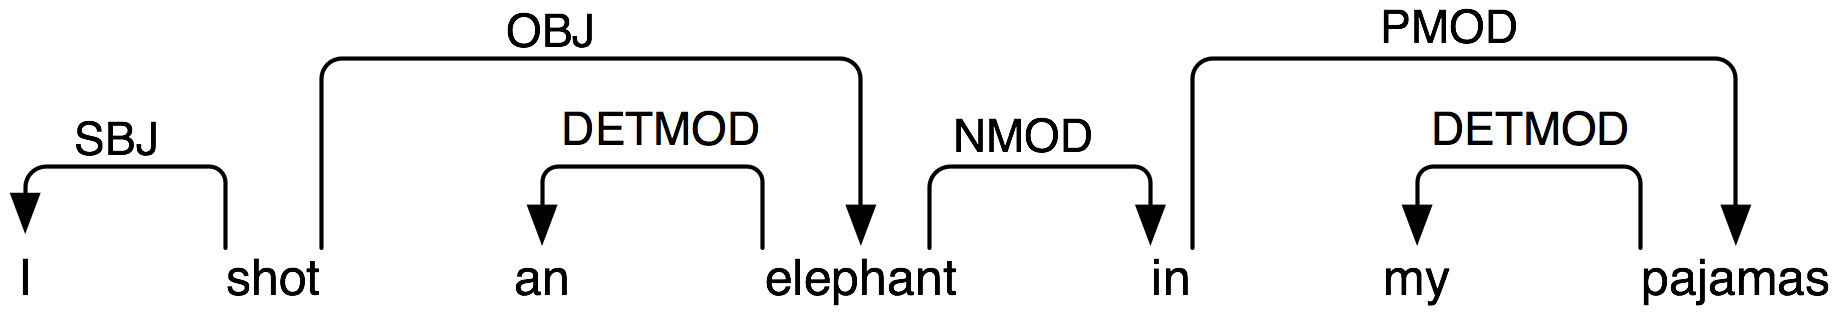)

图 5.1：依存结构：箭头从中心词指向它们的依赖；标签表示依赖的语法功能如：主语、宾语或修饰语。

[5.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#fig-depgraph0)中的弧加了依赖与它的中心词之间的语法功能标签。例如，I是shot（这是整个句子的中心词）的`SBJ`（主语），in是一个`NMOD`（elephant的名词修饰语）。与短语结构语法相比，依存语法可以作为一种依存关系直接用来表示语法功能。

下面是NLTK为依存语法编码的一种方式——注意它只能捕捉依存关系信息，不能指定依存关系类型：

In [17]:
groucho_dep_grammar = nltk.DependencyGrammar.fromstring("""
'shot' -> 'I' | 'elephant' | 'in'
'elephant' -> 'an' | 'in'
'in' -> 'pajamas'
'pajamas' -> 'my'
""")
print(groucho_dep_grammar)

Dependency grammar with 7 productions
  'shot' -> 'I'
  'shot' -> 'elephant'
  'shot' -> 'in'
  'elephant' -> 'an'
  'elephant' -> 'in'
  'in' -> 'pajamas'
  'pajamas' -> 'my'


依存关系图是一个投影，当所有的词都按线性顺序书写，边可以在词上绘制而不会交叉。这等于是说一个词及其所有后代依赖（依赖及其依赖的依赖，等等）在句子中形成一个连续的词序列。[5.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#fig-depgraph0)是一个投影，我们可以使用投影依存关系分析器分析很多英语句子。下面的例子演示`groucho_dep_grammar`如何提供了一种替代的方法来捕捉附着歧义，我们之前在研究短语结构语法中遇到的。

In [18]:
pdp = nltk.ProjectiveDependencyParser(groucho_dep_grammar)
sent = 'I shot an elephant in my pajamas'.split()
trees = pdp.parse(sent)
for tree in trees:
    print(tree)

(shot I (elephant an (in (pajamas my))))
(shot I (elephant an) (in (pajamas my)))


这些括号括起来的依存关系结构也可以显示为树，依赖被作为它们的中心词的孩子。

> VP -> TV NP
>
> TV -> 'chased' | 'saw'

## 5.2 扩大规模

到目前为止，我们只考虑了“玩具语法”，演示分析的关键环节的少量的语法。但有一个明显的问题就是这种做法是否可以扩大到覆盖自然语言的大型语料库。手工构建这样的一套产生式有多么困难？一般情况下，答案是：*非常困难*。即使我们允许自己使用各种形式化的工具，它们可以提供语法产生式更简洁的表示，保持对覆盖一种语言的主要成分所需要的众多产生式之间的复杂的相互作用的控制，仍然是极其困难的。换句话说，很难将语法模块化，每部分语法可以独立开发。反过来这意味着，在一个语言学家团队中分配编写语法的任务是很困难的。另一个困难是当语法扩展到包括更加广泛的成分时，适用于任何一个句子的分析的数量也相应增加。换句话说，歧义随着覆盖而增加。

尽管存在这些问题，一些大的合作项目在为几种语言开发基于规则的语法上已取得了积极的和令人印象深刻的结果。例如，词汇功能语法（LFG）Pargram 项目、中心词驱动短语结构文法（HPSG）LinGO 矩阵框架和词汇化树邻接语法XTAG项目。

## 6 语法开发

分析器根据短语结构语法在句子上建立树。现在，我们上面给出的所有例子只涉及玩具语法包含少数的产生式。如果我们尝试扩大这种方法的规模来处理现实的语言语料库会发生什么？在本节中，我们将看到如何访问树库，并看看开发广泛覆盖的语法的挑战。

<a href="#6.1-树库和语法">6.1 树库和语法</a> 

<a href="#6.2-有害的歧义">6.2 有害的歧义</a> 

vscode jupyter toc

<a href="#61-树库和语法">6.1 树库和语法</a> 

<a href="#62-有害的歧义">6.2 有害的歧义</a> 

## 6.1 树库和语法

`corpus`模块定义了`treebank`语料的阅读器，其中包含了宾州树库语料的10％的样本。

In [19]:
from nltk.corpus import treebank
t = treebank.parsed_sents('wsj_0001.mrg')[0]
print(t)

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


我们可以利用这些数据来帮助开发一个语法。例如，[6.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-sentential-complement)中的程序使用一个简单的过滤器找出带句子补语的动词。假设我们已经有一个形如`VP -> Vs S`的产生式，这个信息使我们能够识别那些包括在`Vs`的扩张中的特别的动词。

In [20]:
def filter(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return  (tree.label() == 'VP') and ('S' in child_nodes)

PP附着语料库`nltk.corpus.ppattach`是另一个有关特别动词配价的信息源。在这里，我们演示挖掘这个语料库的技术。它找出具有固定的介词和名词的介词短语对，其中介词短语附着到`VP`还是`NP`，由选择的动词决定。

In [21]:
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)
...
for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:', sorted(table[key]['N']), 'V:', sorted(table[key]['V']))

%-below-level N: ['left'] V: ['be']
%-from-year N: ['was'] V: ['declined', 'dropped', 'fell', 'grew', 'increased', 'plunged', 'rose', 'was']
%-in-August N: ['was'] V: ['climbed', 'fell', 'leaping', 'rising', 'rose']
%-in-September N: ['increased'] V: ['climbed', 'declined', 'dropped', 'edged', 'fell', 'grew', 'plunged', 'rose', 'slipped']
%-in-week N: ['declined'] V: ['was']
%-to-% N: ['add', 'added', 'backed', 'be', 'cut', 'go', 'grow', 'increased', 'increasing', 'is', 'offer', 'plummet', 'reduce', 'rejected', 'rise', 'risen', 'shaved', 'wants', 'yield', 'zapping'] V: ['fell', 'rise', 'slipped']
%-to-million N: ['declining'] V: ['advanced', 'climbed', 'cutting', 'declined', 'declining', 'dived', 'dropped', 'edged', 'fell', 'gained', 'grew', 'increased', 'jump', 'jumped', 'plunged', 'rising', 'rose', 'slid', 'slipped', 'soared', 'tumbled']
1-to-21 N: ['dropped'] V: ['dropped']
1-to-33 N: ['gained'] V: ['dropped', 'fell', 'jumped']
1-to-4 N: ['added'] V: ['gained']
1-to-47 N: ['jumped']

这个程序的输出行中我们发现`offer-from-group N: ['rejected'] V: ['received']`，这表示received期望一个单独的`PP`附着到`VP`而rejected不是的。和以前一样，我们可以使用此信息来帮助构建语法。

NLTK语料库收集了来自PE08跨框架跨领域分析器评估共享任务的数据。一个更大的文法集合已准备好用于比较不同的分析器，它可以通过下载`large_grammars`包获得（如`python -m nltk.downloader large_grammars`）。

NLTK语料库也收集了*中央研究院树库语料*，包括10,000句已分析的句子，来自*现代汉语中央研究院平衡语料库*。让我们加载并显示这个语料库中的一棵树。

In [22]:
nltk.corpus.sinica_treebank.parsed_sents()[3450].draw()               

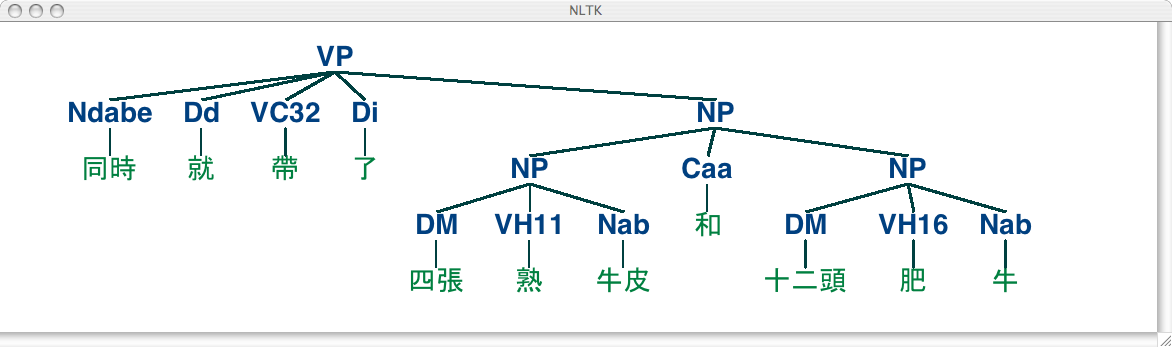

## 6.2 有害的歧义

不幸的是，随着文法覆盖范围的增加和输入句子长度的增长，分析树的数量也迅速增长。事实上，它以天文数字的速度增长。

让我们在一个简单的例子帮助下来探讨这个问题。词fish既是名词又是动词。我们可以造这样的句子fish fish fish，意思是*fish like to fish for other fish*。（用police尝试一下，如果你喜欢更有意思的东西。）下面是“fish”句子的玩具文法。

In [23]:
grammar = nltk.CFG.fromstring("""
S -> NP V NP
NP -> NP Sbar
Sbar -> NP V
NP -> 'fish'
V -> 'fish'
""")

现在，我们可以尝试分析一个较长的句子，fish fish fish fish fish，其中一个意思是：“fish that other fish fish are in the habit of fishing fish themselves”。我们使用NLTK的图表分析器，它在本章前面介绍过。这句话有两种读法。

In [24]:
tokens = ["fish"] * 5
cp = nltk.ChartParser(grammar)
for tree in cp.parse(tokens):
    print(tree)

(S (NP fish) (V fish) (NP (NP fish) (Sbar (NP fish) (V fish))))
(S (NP (NP fish) (Sbar (NP fish) (V fish))) (V fish) (NP fish))


随着句子长度增加到（3，5，7，...），我们得到的分析树的数量是：1; 2; 5; 14; 42; 132; 429; 1,430; 4,862; 16,796; 58,786; 208,012; ….（这是Catalan数，我们在[4](https://usyiyi.github.io/nlp-py-2e-zh/4.html#chap-structured-programming)的练习中见过）。最后一个是句子长度为23的分析树的数目，这是宾州树库WSJ部分的句子的平均长度。对于一个长度为50的句子有超过1012的解析，这只是Piglet 句子长度的一半（[1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#sec-dilemmas)），这些句子小孩可以毫不费力的处理。没有实际的自然语言处理系统可以为一个句子构建数以百万计的树，并根据上下文选择一个合适的。很显然，人也不会这样做！

请注意，这个问题不是只在我们选择的例子中存在。[(Church & Patil, 1982)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#church1982csa)指出`PP`附着句法歧义在像[(18)](https://usyiyi.github.io/nlp-py-2e-zh/8.html#ex-pp)这样的句子中也是按Catalan数的比例增长。

In [25]:
def give(t):
    return t.label() == 'VP' and len(t) > 2 and t[1].label() == 'NP'\
           and (t[2].label() == 'PP-DTV' or t[2].label() == 'NP')\
           and ('give' in t[0].leaves() or 'gave' in t[0].leaves())
def sent(t):
    return ' '.join(token for token in t.leaves() if token[0] not in '*-0')
def print_node(t, width):
        output = "%s %s: %s / %s: %s" %\
            (sent(t[0]), t[1].label(), sent(t[1]), t[2].label(), sent(t[2]))
        if len(output) > width:
            output = output[:width] + "..."
        print(output)

我们可以观察到一种强烈的倾向就是最短的补语最先出现。然而，这并没有解释类似`give NP: federal judges / NP: a raise`的形式，其中有生性起了重要作用。事实上，根据[(Bresnan & Hay, 2006)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#bresnan2006gg)的调查，存在大量的影响因素。这些偏好可以用加权语法来表示。

概率上下文无关语法（或*PCFG*）是一种上下文无关语法，它的每一个产生式关联一个概率。它会产生与相应的上下文无关语法相同的文本解析，并给每个解析分配一个概率。PCFG产生的一个解析的概率仅仅是它用到的产生式的概率的乘积。

最简单的方法定义一个PCFG 是从一个加权产生式序列组成的特殊格式的字符串加载它，其中权值出现在括号里，如[6.4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-pcfg1)所示。

In [26]:
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)

有时可以很方便的将多个产生式组合成一行，如`VP -> TV NP [0.4] | IV [0.3] | DatV NP NP [0.3]`。为了确保由文法生成的树能形成概率分布，PCFG语法强加了约束，产生式所有给定的左侧的概率之和必须为1。[6.4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-pcfg1)中的语法符合这个约束：对`S`只有一个产生式，它的概率是1.0；对于`VP`，0.4+0.3+0.3=1.0；对于`NP`，0.8+0.2=1.0。`parse()`返回的分析树包含概率：

In [28]:
viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
    print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)


现在，分析树被分配了概率，一个给定的句子可能有数量庞大的可能的解析就不再是问题。分析器将负责寻找最有可能的解析。

## 7 小结

- 句子都有内部组织结构，可以用一棵树表示。组成结构的显著特点是：递归、中心词、补语和修饰语。
- 语法是一个潜在的无限的句子集合的一个紧凑的特性；我们说，一棵树是符合语法规则的或语法树授权一棵树。
- 语法是用于描述一个给定的短语是否可以被分配一个特定的成分或依赖结构的一种形式化模型。
- 给定一组句法类别，上下文无关文法使用一组生产式表示某类型*A*的短语如何能够被分析成较小的序列α1 αn。
- 依存语法使用产生式指定给定的中心词的依赖是什么。
- 一个句子有一个以上的句法分析就产生句法歧义（如介词短语附着歧义）。
- 分析器是一个过程，为符合语法规则的句子寻找一个或多个相应的树。
- 一个简单的自上而下分析器是递归下降分析器，在语法产生式的帮助下递归扩展开始符号（通常是`S`），尝试匹配输入的句子。这个分析器并不能处理左递归产生式（如`NP -> NP PP`）。它盲目扩充类别而不检查它们是否与输入字符串兼容的方式效率低下，而且会重复扩充同样的非终结符然后丢弃结果。
- 一个简单的自下而上的分析器是移位-规约分析器，它把输入移到一个堆栈中，并尝试匹配堆栈顶部的项目和语法产生式右边的部分。这个分析器不能保证为输入找到一个有效的解析，即使它确实存在，它建立子结构而不检查它是否与全部语法一致。

## 8 深入阅读

本章的附加材料发布在`http://nltk.org/`，包括网络上免费提供的资源的链接。关于使用NLTK分析的更多的例子，请看在`http://nltk.org/howto`上的分析HOWTO。

有许多关于句法的入门书籍。[(O'Grady et al, 2004)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#ogrady2004)是一个语言学概论，而[(Radford, 1988)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#radford1988tg)以容易接受的方式介绍转换语法，推荐其中的无限制依赖结构的转换文法。在形式语言学中最广泛使用的术语是生成语法，虽然它与生成并没有关系[(Chomsky, 1965)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#chomsky1965)。X-bar句法来自于[(Jacobs & Rosenbaum, 1970)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#chomsky1970rn)，并在[(Jackendoff, 1977)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#jackendoff1977xs)得到更深的拓展（The primes we use replace Chomsky's typographically more demanding horizontal bars）。

[(Burton-Roberts, 1997)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#burtonroberts1997as)是一本面向实践的关于如何分析英语成分的教科书，包含广泛的例子和练习。[(Huddleston & Pullum, 2002)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#huddleston2002cge)提供了一份最新的英语句法现象的综合分析。

[(Jurafsky & Martin, 2008)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#jurafskymartin2008)的第12章讲述英语的形式文法；13.1-3节讲述简单的分析算法和歧义处理技术；第14章讲述统计分析；第16章讲述乔姆斯基层次和自然语言的形式复杂性。[(Levin, 1993)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#levin1993)根据它们的句法属性，将英语动词划分成更细的类。

有几个正在进行的建立大规模的基于规则的语法的项目，如LFG Pargram 项目`http://www2.parc.com/istl/groups/nltt/pargram/`，HPSG LinGO 矩阵框架`http://www.delph-in.net/matrix/`以及XTAG 项目`http://www.cis.upenn.edu/~xtag/`。

## 9 练习

1. ☼ 你能想出符合语法的却可能之前从来没有被说出的句子吗？（与伙伴轮流进行。）这告诉你关于人类语言的什么？

2. ☼ 回想一下Strunk和White的禁止在句子开头使用however表示“although”的意思。在网上搜索句子开头使用的however。这个成分使用的有多广泛？

3. ☼ 思考句子Kim arrived or Dana left and everyone cheered。用括号的形式表示and和or的相对范围。产生这两种解释对应的树结构。

4. ☼ `Tree`类实现了各种其他有用的方法。请看`Tree`帮助文档查阅更多细节（如导入Tree类，然后输入`help(Tree)`）。

5. ☼ 在本练习中，你将手动构造一些分析树。

   1. 编写代码产生两棵树，对应短语old men and women的不同读法
   2. 将本章中表示的任一一颗树编码为加标签的括号括起的形式，使用`nltk.Tree()`检查它是否符合语法。使用`draw()`显示树。
   3. 如(a) 中那样，为The woman saw a man last Thursday画一棵树。

6. ☼ 写一个递归函数，遍历一颗树，返回树的深度，一颗只有一个节点的树的深度应为0。（提示：子树的深度是其子女的最大深度加1。）

7. ☼ 分析A.A. Milne 关于Piglet 的句子，为它包含的所有句子画下划线，然后用`S`替换这些（如第一句话变为`S` when:lx` `S`）。为这种“压缩”的句子画一个树形结构。用于建立这样一个长句的主要的句法结构是什么？

8. ☼ 在递归下降分析器的演示中，通过选择*Edit*菜单上的*Edit Text*改变实验句子。

9. ☼ `grammar1`中的语法能被用来描述长度超过20 词的句子吗？

10. ☼ 使用图形化图表分析器接口，尝试不同的规则调用策略做实验。拿出你自己的可以使用图形界面手动执行的策略。描述步骤，并报告它的任何效率的提高（例如用结果图表示大小）。这些改进取决于语法结构吗？你觉得一个更聪明的规则调用策略能显著提升性能吗？

11. ☼ 对于一个你已经见过的或一个你自己设计的CFG，用笔和纸手动跟踪递归下降分析器和移位-规约分析器的执行。

12. ☼ 我们已经看到图表分析器增加边而从来不从图表中删除的边。为什么？

13. ☼ 思考词序列：Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo。如`http://en.wikipedia.org/wiki/Buffalo_buffalo_Buffalo_buffalo_buffalo_buffalo_Buffalo_buffalo`解释的，这是一个语法正确的句子。思考此维基百科页面上表示的树形图，写一个合适的语法。正常情况下是小写，模拟听到这句话时听者会遇到的问题。你能为这句话找到其他的解析吗？当句子变长时分析树的数量如何增长？（这些句子的更多的例子可以在`http://en.wikipedia.org/wiki/List_of_homophonous_phrases`找到。）

14. ◑ 你可以通过选择*Edit* 菜单上的*Edit Grammar*修改递归下降分析器演示程序。改变第二次扩充产生式，即`NP -> Det N PP`为`NP -> NP PP`。使用*Step*按钮，尝试建立一个分析树。发生了什么？

15. ◑ 扩展`grammar2`中的语法，将产生式中的介词扩展为不及物的，及物的和需要`PP`补语的。基于这些产生式，使用前面练习中的方法为句子Lee ran away home画一棵树。

16. ◑ 挑选一些常用动词，完成以下任务：

1. 写一个程序在PP附着语料库`nltk.corpus.ppattach`找到那些动词。找出任何这样的情况，相同的动词有两种不同的附着，其中第一个是名词，或者第二个是名词，或者介词保持不变（正如我们在[2](https://usyiyi.github.io/nlp-py-2e-zh/8.html#sec-whats-the-use-of-syntax)句法歧义中讨论过的）。
2. 制定CFG语法产生式涵盖其中一些情况。

17. ◑ 写一个程序，比较自上而下的图表分析器与递归下降分析器的效率（[4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#sec-parsing)）。使用相同的语法和输入的句子。使用`timeit`模块比较它们的性能（见[4.7](https://usyiyi.github.io/nlp-py-2e-zh/4.html#sec-algorithm-design)，如何做到这一点的一个例子）。

18. 比较自上而下、自下而上和左角落分析器的性能，使用相同的语法和3个符合语法的测试句子。使用`timeit`记录每个分析器在同一个句子上花费的时间。写一个函数，在这三句话上运行这三个分析器，输出3×3格的时间，以及行和列的总计。讨论你的发现。

19. ◑ 阅读“garden path”的句子。一个分析器的计算工作与人类处理这些句子的困难性有什么关系？`http://en.wikipedia.org/wiki/Garden_path_sentence`

20. ◑ 若要在一个窗口比较多个树，我们可以使用`draw_trees()`方法。定义一些树，尝试一下：

```
from nltk.draw.tree import draw_trees
draw_trees(tree1, tree2, tree3)                    
```

21. ◑ 使用树中的位置，列出宾州树库前100个句子的主语；为了使结果更容易查看，限制从高度最高为2的子树提取主语。

22. ◑ 查看PP附着语料库，尝试提出一些影响`PP`附着的因素。

23. ◑ 在本节中，我们说过简单的用术语n-grams不能描述所有语言学规律。思考下面的句子，尤其是短语in his turn的位置。这是基于n-grams 的方法的一个问题吗？

> What was more, the in his turn somewhat youngish Nikolay Parfenovich also turned out to be the only person in the entire world to acquire a sincere liking to our "discriminated-against" public procurator. (Dostoevsky: The Brothers Karamazov)

24. ◑ 编写一个递归函数产生嵌套的括号括起的形式的一棵树，显示去掉叶节点之后的子树的非终结符。于是上面的关于Pierre Vinken 的例子会产生：`[[[NNP NNP]NP , [ADJP [CD NNS]NP JJ]ADJP ,]NP-SBJ MD [VB [DT NN]NP [IN [DT JJ NN]NP]PP-CLR [NNP CD]NP-TMP]VP .]S`。连续的类别应用空格分隔。

25. ◑ 从古登堡工程下载一些电子图书。写一个程序扫描这些文本中任何极长的句子。你能找到的最长的句子是什么？这么长的句子的句法结构是什么？

26. ◑ 修改函数`init_wfst()`和`complete_wfst()`，使WFST中每个单元的内容是一组非终端符而不是一个单独的非终结符。

27. ◑ 思考[4.4](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-wfst)中的算法。你能解释为什么分析上下文无关语法是与n3成正比的，其中*n*是输入句子的长度。

28. ◑ 处理宾州树库语料库样本`nltk.corpus.treebank`中的每棵树，在`Tree.productions()`的帮助下提取产生式。丢弃只出现一次的产生式。具有相同的左侧和类似的右侧的产生式可以被折叠，产生一个等价的却更紧凑的规则集。编写代码输出一个紧凑的语法。

29. ★ 英语中定义句子`S`的主语的一种常见的方法是作为`S` *的名词短语孩子*和`VP`的*兄弟*。写一个函数，以一句话的树为参数，返回句子主语对应的子树。如果传递给这个函数的树的根节点不是`S`或它缺少一个主语，应该怎么做？

30. ★ 写一个函数，以一个语法（如[3.1](https://usyiyi.github.io/nlp-py-2e-zh/8.html#code-cfg1)定义的语法）为参数，返回由这个语法随机产生的一个句子。（使用`grammar.start()`找出语法的开始符号；`grammar.productions(lhs)`得到具有指定左侧的语法的产生式的列表；`production.rhs()`得到一个产生式的右侧。）

31. ★ 使用回溯实现移位-规约分析器的一个版本，使它找出一个句子所有可能的解析，它可以被称为“递归上升分析器”。咨询维基百科关于回溯的条目`http://en.wikipedia.org/wiki/Backtracking`

32. ★ 正如我们在[7.](https://usyiyi.github.io/nlp-py-2e-zh/7.html#chap-chunk)中所看到的，可以将词块表示成它们的词块标签。当我们为包含gave的句子做这个的时候，我们发现如以下模式：


> gave NP
> 
> gave up NP in NP
> 
> gave NP up
> 
> gave NP NP
> 
> gave NP to NP